# Main Idea

The main goal of this application is to detect heart disease with given information in the test dataset. In train datasets with multiple features are pieces of information on patient medical records. The column "target" indicates if each patient has heart disease. 

The approach of the work is listed below follow:
Data preparation => Model Selection => Evaluate modes => Choose best model => Predict with test dataset => Present result



In [34]:
import numpy as np
import pandas as pd
np.random.seed(42)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score,r2_score,f1_score, precision_score, recall_score
from sklearn.metrics import silhouette_score, rand_score, davies_bouldin_score, r2_score,roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import  GridSearchCV
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt

## A.  Data Preparation

### Read Data

Datasets given by Kaggle.com are included in two separate files. In train.csv, there are multiple features with one label. The file "test.csv" has the same features but the label(output) is not included. Therefore, in order to build a supervised model, dataset "train.csv" must be split into "train_date" and "test_data".

Column List: HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, Diabetes, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age, Education, Income, target

--Feature list: HighBP, HighChol, CholCheck, BMI, Smoker, Stroke, Diabetes, PhysActivity, Fruits, Veggies, HvyAlcoholConsump, AnyHealthcare, NoDocbcCost, GenHlth, MentHlth, PhysHlth, DiffWalk, Sex, Age, Education, Income, target


--Prediction list: target

In [35]:
def read_data():
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    return train_data, test_data

### Remove Failed and Null Data

In [36]:
#Choose features and prediction and Drop unwanted data
def fea_select(train_data, test_data, feature, prediction):
    Xtrain = train_data[feature]
    Ytrain = train_data[prediction]
    Xtest = test_data[feature]
    Ytest = test_data[prediction]
    return Xtrain, Ytrain, Xtest, Ytest

### Split dataset

In [37]:
def TrainTestSplit(X, Y):
    #write function here
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size =0.25, random_state=42, stratify =Y)
    return Xtrain, Xtest, ytrain, ytest

### Normolization

In [38]:
def MinMax_Norm(X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

### Separate Data

To prevent extreme values from dominating the model and affecting training results, this project will also evaluate with partial normalized features. Features with actual values or real numbers can be considered to be normalized. For example, age and BMI.

In [39]:
#Drop unuseful feature and normalize data
train_data, test_data = read_data()
Y = train_data['target']
X = train_data.drop(['target','PatientID'], axis = 'columns')
X1 = train_data.drop(['target','PatientID'], axis = 'columns')
X2 = X1.copy(deep=True)
X3 = train_data.drop(['target','PatientID'], axis = 'columns')
scaler = MinMaxScaler()
X2[['BMI']] = scaler.fit_transform(X2[['BMI']])
X2[['MentHlth']] = scaler.fit_transform(X2[['MentHlth']])
X2[['PhysHlth']] = scaler.fit_transform(X2[['PhysHlth']])
X2[['Age']] = scaler.fit_transform(X2[['Age']])
X3 = scaler.fit_transform(X3)
X3 = pd.DataFrame(X3, columns = [X.columns])
display(X1)
display(X2)
display(X3)
#X1: No Normalize
#X2: Partial Normalize
#X3: All Normalize

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,29,0,0,0,1,1,1,...,1,0,3,0,0,0,0,13,5,8
1,1,0,1,30,0,1,2,0,0,0,...,0,0,2,0,0,0,0,9,5,6
2,0,0,1,31,0,0,0,1,1,1,...,1,0,2,0,7,0,0,10,6,8
3,0,0,1,36,0,0,2,0,0,1,...,1,0,2,0,0,0,0,11,5,6
4,0,1,1,29,0,0,0,1,1,1,...,1,0,4,0,0,1,1,10,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1,1,1,22,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,4,7
177572,0,0,1,26,0,0,0,1,1,1,...,1,0,2,0,0,0,0,7,4,7
177573,0,0,1,26,0,0,0,1,1,1,...,0,0,1,0,0,0,0,6,6,5
177574,1,0,1,25,0,0,0,1,0,1,...,1,0,3,0,2,0,1,11,6,7


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,0.197674,0,0,0,1,1,1,...,1,0,3,0.000000,0.000000,0,0,1.000000,5,8
1,1,0,1,0.209302,0,1,2,0,0,0,...,0,0,2,0.000000,0.000000,0,0,0.666667,5,6
2,0,0,1,0.220930,0,0,0,1,1,1,...,1,0,2,0.000000,0.233333,0,0,0.750000,6,8
3,0,0,1,0.279070,0,0,2,0,0,1,...,1,0,2,0.000000,0.000000,0,0,0.833333,5,6
4,0,1,1,0.197674,0,0,0,1,1,1,...,1,0,4,0.000000,0.000000,1,1,0.750000,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1,1,1,0.116279,0,0,0,1,1,1,...,1,0,2,0.000000,0.000000,0,0,0.833333,4,7
177572,0,0,1,0.162791,0,0,0,1,1,1,...,1,0,2,0.000000,0.000000,0,0,0.500000,4,7
177573,0,0,1,0.162791,0,0,0,1,1,1,...,0,0,1,0.000000,0.000000,0,0,0.416667,6,5
177574,1,0,1,0.151163,0,0,0,1,0,1,...,1,0,3,0.000000,0.066667,0,1,0.833333,6,7


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,0.0,1.000000,0.8,1.000000
1,1.0,0.0,1.0,0.209302,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.666667,0.8,0.714286
2,0.0,0.0,1.0,0.220930,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.233333,0.0,0.0,0.750000,1.0,1.000000
3,0.0,0.0,1.0,0.279070,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.833333,0.8,0.714286
4,0.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.75,0.000000,0.000000,1.0,1.0,0.750000,1.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1.0,1.0,1.0,0.116279,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.833333,0.6,0.857143
177572,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.500000,0.6,0.857143
177573,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.416667,1.0,0.571429
177574,1.0,0.0,1.0,0.151163,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.000000,0.066667,0.0,1.0,0.833333,1.0,0.857143


## B. Models

Since there are labels in the dataset and for better prediction result, the project implements multiple supervised classifiers. 

In [40]:
def LogisticModel(Xtrain, ytrain):
    model = LogisticRegression(max_iter=1000000)
    mySupervisedModel = model.fit(Xtrain, ytrain)
    return mySupervisedModel

In [41]:
def ClusteringModel(Xtrain, ytrain):
    #Normalize features
    scaler = MinMaxScaler()
    scaler.fit(Xtrain)
    Xtrain = scaler.transform(Xtrain)
    # Apply K - mean
    km = KMeans(n_clusters=2, random_state=42)
    myClusteringModel = km.fit(Xtrain)
    return myClusteringModel 

In [42]:
# Linear models are not appliable in the case
def LinearModel(Xtrain, ytrain):
    model = Pipeline([('linear_regression', LinearRegression())])
    myLinearModel = model.fit(Xtrain, ytrain)
    return myLinearModel

In [43]:
def DTModel(Xtrain, ytrain): #Decision Tree Model
    model = DecisionTreeClassifier()
    myDTModel = model.fit(Xtrain, Ytrain)
    return myDTModel

In [44]:
def RFModel(Xtrain, ytrain): #Random Forest Model
    model = RandomForestClassifier(n_estimators = 300)
    myRFModel = model.fit(Xtrain, Ytrain)
    return myRFModel

In [45]:
def NNModel(X_train, y_train, ep= 100):
    NN_model = Sequential()
    NN_model.add(Dense(29, input_shape=(None, 13), activation='tanh'))
    NN_model.add(Dense(24, activation='tanh'))
    NN_model.add(Dense(19, activation='tanh'))
    NN_model.add(Dense(1))
    NN_model.compile(optimizer = 'SGD', loss='mse')
    print(NN_model.summary())
    NN_model.fit(X_train, y_train, epochs = ep)
    return myNNmodel

## C. Evaluation Models

In [46]:
def clas_metric():
    #calculate classification metrics

    #confusion matrix
    #Exercise: the manual calculation of the confusion matrix will not be shown. As an exercise, try implementing it and check to make sure your values correspond to those obtained by the confusion_matrix function in Sklearn

    tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred2).ravel()
    print("The confusion matrix function returned:\nTrue Negatives:\t\t{0}\nTrue Positives:\t\t{1}\nFalse Negatives:\t{2}\nFalse Positives:\t{3}\n".format(tn,tp,fn,fp))

    #accuracy
    manual_accuracy = (tp + tn)/(tp + tn + fp +fn)
    calculated_accuracy = accuracy_score(y_test_new, y_pred2)
    print("The manually computed Accuracy is:\t{0}".format(manual_accuracy))
    print("The Accuracy computed by Sklearn is:\t{0}\n".format(calculated_accuracy))

    #precision
    manual_precision = (tp)/(tp +fp)
    calculated_precision = precision_score(y_test_new, y_pred2)
    print("The manually computed Precision is:\t{0}".format(manual_precision))
    print("The Precision computed by Sklearn is:\t{0}\n".format(calculated_precision))

    #precision
    manual_recall = (tp)/(tp +fn)
    calculated_recall = recall_score(y_test_new, y_pred2)
    print("The manually computed Recall is:\t{0}".format(manual_recall))
    print("The Recall computed by Sklearn is:\t{0}\n".format(calculated_recall))

    #f1 score
    manual_f1 = (tp)/(tp + 0.5*(fp+fn))
    calculated_f1 = f1_score(y_test_new, y_pred2)
    print("The manually computed F1 Score is:\t{0}".format(manual_f1))
    print("The F1 Score computed by Sklearn is:\t{0}\n".format(calculated_f1))

In [47]:
def perflogisticModel(Xtrain, Xtest, ytrain, ytest, model):
    accuracy = accuracy_score(ytrain, model.predict(Xtrain)) #metrics for train predictions
    precision = precision_score(ytest, model.predict(Xtest)) #metrics for test predictions
    return accuracy, precision

In [48]:
def perfclusterModel(Xtrain,Xtest,ytrain,ytest):
    f1=f1_score(ytest,pred_cluster,average='weighted', labels=np.unique(pred_cluster))
    auc=roc_auc_score(ytest,pred_cluster,average='weighted', labels=np.unique(pred_cluster))
    accuracy=accuracy_score(ytest,pred_cluster)
    return f1, auc, accuracy

## D. Main Code: Application 1 - Kaggle's heart disease detection

In [49]:
#Drop unuseful feature and normalize data
train_data, test_data = read_data()
Y = train_data['target']
X = train_data.drop(['target','PatientID'], axis = 'columns')
X1 = train_data.drop(['target','PatientID'], axis = 'columns')
X2 = X1.copy(deep=True)
X3 = train_data.drop(['target','PatientID'], axis = 'columns')
scaler = MinMaxScaler()
X2[['BMI']] = scaler.fit_transform(X2[['BMI']])
X2[['MentHlth']] = scaler.fit_transform(X2[['MentHlth']])
X2[['PhysHlth']] = scaler.fit_transform(X2[['PhysHlth']])
X2[['Age']] = scaler.fit_transform(X2[['Age']])
X3 = scaler.fit_transform(X3)
X3 = pd.DataFrame(X3, columns = [X.columns])
display(X1)
display(X2)
display(X3)
#X1: No Normalize
#X2: Partial Normalize
#X3: All Normalize

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,29,0,0,0,1,1,1,...,1,0,3,0,0,0,0,13,5,8
1,1,0,1,30,0,1,2,0,0,0,...,0,0,2,0,0,0,0,9,5,6
2,0,0,1,31,0,0,0,1,1,1,...,1,0,2,0,7,0,0,10,6,8
3,0,0,1,36,0,0,2,0,0,1,...,1,0,2,0,0,0,0,11,5,6
4,0,1,1,29,0,0,0,1,1,1,...,1,0,4,0,0,1,1,10,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1,1,1,22,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,4,7
177572,0,0,1,26,0,0,0,1,1,1,...,1,0,2,0,0,0,0,7,4,7
177573,0,0,1,26,0,0,0,1,1,1,...,0,0,1,0,0,0,0,6,6,5
177574,1,0,1,25,0,0,0,1,0,1,...,1,0,3,0,2,0,1,11,6,7


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,0.197674,0,0,0,1,1,1,...,1,0,3,0.000000,0.000000,0,0,1.000000,5,8
1,1,0,1,0.209302,0,1,2,0,0,0,...,0,0,2,0.000000,0.000000,0,0,0.666667,5,6
2,0,0,1,0.220930,0,0,0,1,1,1,...,1,0,2,0.000000,0.233333,0,0,0.750000,6,8
3,0,0,1,0.279070,0,0,2,0,0,1,...,1,0,2,0.000000,0.000000,0,0,0.833333,5,6
4,0,1,1,0.197674,0,0,0,1,1,1,...,1,0,4,0.000000,0.000000,1,1,0.750000,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1,1,1,0.116279,0,0,0,1,1,1,...,1,0,2,0.000000,0.000000,0,0,0.833333,4,7
177572,0,0,1,0.162791,0,0,0,1,1,1,...,1,0,2,0.000000,0.000000,0,0,0.500000,4,7
177573,0,0,1,0.162791,0,0,0,1,1,1,...,0,0,1,0.000000,0.000000,0,0,0.416667,6,5
177574,1,0,1,0.151163,0,0,0,1,0,1,...,1,0,3,0.000000,0.066667,0,1,0.833333,6,7


,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.50,0.000000,0.000000,0.0,0.0,1.000000,0.8,1.000000
1,1.0,0.0,1.0,0.209302,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.666667,0.8,0.714286
2,0.0,0.0,1.0,0.220930,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.233333,0.0,0.0,0.750000,1.0,1.000000
3,0.0,0.0,1.0,0.279070,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.833333,0.8,0.714286
4,0.0,1.0,1.0,0.197674,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.75,0.000000,0.000000,1.0,1.0,0.750000,1.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177571,1.0,1.0,1.0,0.116279,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.833333,0.6,0.857143
177572,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.25,0.000000,0.000000,0.0,0.0,0.500000,0.6,0.857143
177573,0.0,0.0,1.0,0.162791,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.416667,1.0,0.571429
177574,1.0,0.0,1.0,0.151163,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.50,0.000000,0.066667,0.0,1.0,0.833333,1.0,0.857143


In [50]:
#Splite data
Xtrain, Xtest, Ytrain, Ytest = TrainTestSplit(X, Y)
Xtrain1, Xtest1, Ytrain, Ytest = TrainTestSplit(X1, Y)
Xtrain2, Xtest2, Ytrain, Ytest = TrainTestSplit(X2, Y)
Xtrain3, Xtest3, Ytrain, Ytest = TrainTestSplit(X3, Y)
#X1: No Normalize
#X2: Partial Normalize
#X3: All Normalize

### Train with Not Normalized Data

In [51]:
#Apply Logistic Model
myLogisticModel = LogisticModel(Xtrain, Ytrain)
pred_Logistic= myLogisticModel.predict(Xtest)
acc_Logistic = accuracy_score(pred_Logistic,Ytest)
print("Logistic Model training completed")

#Apply Clustering Model
myClusteringModel = ClusteringModel(Xtrain, Ytrain)
pred_Cluster= np.logical_not(myClusteringModel.predict(Xtest)).astype(int)
acc_Cluster = accuracy_score(pred_Cluster,Ytest)
print("Clustering Model training completed")

#Apply Decision Tree Model
myDTModel = DTModel(Xtrain, Ytrain)
pred_DT = myDTModel.predict(Xtest)
acc_DT = accuracy_score(pred_DT, Ytest)
print("Decision Tree Model training completed")

#Apply Random Forest Model
myRFModel = RFModel(Xtrain, Ytrain)
pred_RF = myRFModel.predict(Xtest)
acc_RF = accuracy_score(pred_RF, Ytest)
print("Random Forest Model training completed")

#Apply XGB model
XGB = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, objective='binary:logistic', 
                    booster='gbtree', n_jobs=2, gamma=0.001,subsample=1,colsample_bytree=1, colsample_bylevel=1,             # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                    colsample_bynode=1,reg_alpha=1,reg_lambda=0, scale_pos_weight=1, base_score=0.5, random_state=20201107,        # Seed
                   )

myXGBModel = XGB.fit(Xtrain, Ytrain)
pred_XGB = myXGBModel.predict(Xtest)
acc_XGB = accuracy_score(pred_XGB, Ytest)
print("XGB Model training completed")

Logistic Model training completed


C:\Users\JEFF LEE\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Clustering Model training completed
Decision Tree Model training completed
Random Forest Model training completed
[17:51:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\JEFF LEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGB Model training completed


### Train with Normalized Data

In [52]:
#Apply Logistic Model
myLogisticModel = LogisticModel(Xtrain2, Ytrain)
pred_Logistic_N = myLogisticModel.predict(Xtest2)
acc_Logistic = accuracy_score(pred_Logistic_N,Ytest)

#Apply Clustering Model
myClusteringModel = ClusteringModel(Xtrain2, Ytrain)
pred_Cluster_N = np.logical_not(myClusteringModel.predict(Xtest2)).astype(int)
acc_Cluster = accuracy_score(pred_Cluster_N,Ytest)

#Apply Decision Tree Model
myDTModel = DTModel(Xtrain2, Ytrain)
pred_DT_N  = myDTModel.predict(Xtest2)
acc_DT = accuracy_score(pred_DT_N, Ytest)

#Apply Random Forest Model
myRFModel = RFModel(Xtrain2, Ytrain)
pred_RF_N  = myRFModel.predict(Xtest2)
acc_RF = accuracy_score(pred_RF_N, Ytest)

#Apply XGB model
XGB = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, objective='binary:logistic', 
                    booster='gbtree', n_jobs=2, gamma=0.001,subsample=1,colsample_bytree=1, colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                    colsample_bynode=1,reg_alpha=1,reg_lambda=0, scale_pos_weight=1, base_score=0.5, random_state=20201107,        # Seed
                   )

myXGBModel = XGB.fit(Xtrain2, Ytrain)
pred_XGB_N  = myXGBModel.predict(Xtest2)
acc_XGB = accuracy_score(pred_XGB_N, Ytest)

C:\Users\JEFF LEE\anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KMeans was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\JEFF LEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Evaluation Model

Following cell of code present the evaluation results of each model with both normalized and non-normalized datas. As result, XGB model perform the best. Therefore, the porject will predict heart disease from test.csv dataset with XGB model. 

In [53]:
def evaluate(Ytest, Ypred):
    accuracy = accuracy_score(Ytest, Ypred)
    precision = precision_score(Ytest, Ypred)
    recall = recall_score(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)
    return accuracy, precision, recall, f1
    
#No Normalize(accuracy, precision, recall, f1)
print("Logistic Model Evaluation(Without Normalize):", evaluate(Ytest, pred_Logistic))
print("Clustering  Model Evaluation(Without Normalize):", evaluate(Ytest, pred_Cluster))
print("Decision Tree Model Evaluation(Without Normalize):", evaluate(Ytest, pred_DT))
print("Random Forest Model Evaluation(Without Normalize):", evaluate(Ytest, pred_RF))
print("XGB Model Evaluation(Without Normalize):", evaluate(Ytest, pred_XGB))

#Normalize(accuracy, precision, recall, f1)
print("Logistic Model Evaluation:", evaluate(Ytest, pred_Logistic_N))
print("Clustering  Model Evaluation:", evaluate(Ytest, pred_Cluster_N))
print("Decision Tree Model Evaluation:", evaluate(Ytest, pred_DT_N))
print("Random Forest Model Evaluation:", evaluate(Ytest, pred_RF_N))
print("XGB Model Evaluation:", evaluate(Ytest, pred_XGB_N))

Logistic Model Evaluation(Without Normalize): (0.9074424471775465, 0.538961038961039, 0.11911026070318105, 0.19510284035259548)
Clustering  Model Evaluation(Without Normalize): (0.7690904176240032, 0.003598298985933922, 0.0052618990672088015, 0.004273919378339)
Decision Tree Model Evaluation(Without Normalize): (0.8491237554624499, 0.2339885859226379, 0.2647691939727338, 0.2484290843806104)
Random Forest Model Evaluation(Without Normalize): (0.9038608821011849, 0.4511784511784512, 0.09614924659172447, 0.1585173501577287)
XGB Model Evaluation(Without Normalize): (0.9082758931387125, 0.582701062215478, 0.09184405644582636, 0.1586776859504132)
Logistic Model Evaluation: (0.9074424471775465, 0.538961038961039, 0.11911026070318105, 0.19510284035259548)
Clustering  Model Evaluation: (0.20412668378609722, 0.05228664232947196, 0.43506338196603683, 0.09335386194508596)
Decision Tree Model Evaluation: (0.8505653917196018, 0.23820704375667023, 0.26692178904568287, 0.2517482517482518)
Random Fores

### Result of Kaggle's heart disease detection

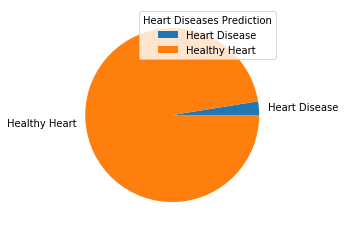

2.530747398297067 % of population may have heart disease


In [54]:
test_data
X = test_data.drop(['PatientID'], axis = 'columns')
pred_XGB = myXGBModel.predict(X)
Posi =np.count_nonzero(pred_XGB == 1)
Neg = len(pred_XGB) - Posi
y = np.array([Posi, Neg])
mylabels = ["Heart Disease", "Healthy Heart"]

plt.pie(y, labels = mylabels)
plt.legend(title = "Heart Diseases Prediction")
plt.show()
print(Posi/(Posi + Neg)*100, "% of population may have heart disease")